- generate all features beforehand and store: may have to cache in .tmp dir
- train N classifiers over the N sets of (increasing) labels
- apply each N classifier, compute miou, store

In [1]:
import numpy as np
import torch
from os import listdir

from yoeo.main import get_dv2_model, get_upsampler_and_expr

from interactive_seg_backend.configs import FeatureConfig, TrainingConfig


from is_helpers import AllowedDatasets, eval_preds, get_pca_over_images_or_dir, get_and_cache_features_over_images, train_model_over_images, apply_model_over_images
    
from typing import Literal

SEED = 10672
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = "cuda:1"

N CPUS: 110


In [2]:
dv2 = get_dv2_model(True, device=DEVICE)

model_path = "../trained_models/e5000_full_fit_reg.pth"
cfg_path = "../yoeo/models/configs/combined_no_shift.json"

upsampler, expr = get_upsampler_and_expr(model_path, cfg_path, device=DEVICE)

Using cache found in /home/ronan/.cache/torch/hub/ywyue_FiT3D_main


In [3]:
PATH = "fig_data/is_benchmark"
AllowedDatasets = Literal["Ni_superalloy_SEM", "T_cell_TEM", "Cu_ore_RLM"]
dataset: tuple[AllowedDatasets, ...] = ("Ni_superalloy_SEM", "T_cell_TEM", "Cu_ore_RLM")

chosen_dataset = "Ni_superalloy_SEM"
fnames = sorted(listdir(f"{PATH}/{chosen_dataset}/images/"))
images = [f"{PATH}/{chosen_dataset}/images/{fname}" for fname in fnames]

In [4]:
pca = get_pca_over_images_or_dir(images, dv2)

feat_cfg = FeatureConfig()
train_cfg = TrainingConfig(feat_cfg, n_samples=-1, add_dino_features=True, classifier='xgb', classifier_params = {"class_weight": "balanced", "max_depth": 32,})
classical_train_cfg = TrainingConfig(feat_cfg, n_samples=-1, add_dino_features=False, classifier='xgb', classifier_params = {"class_weight": "balanced", "max_depth": 32,})

In [5]:
get_and_cache_features_over_images(chosen_dataset, train_cfg, '.tmp', PATH, dv2, upsampler, expr, pca)
get_and_cache_features_over_images(chosen_dataset, classical_train_cfg, '.tmp_classical', PATH, dv2, upsampler, expr, pca)

In [6]:
base_labels = ["000", "001", "005", "007"]
all_label_paths = sorted(listdir(f"{PATH}/{chosen_dataset}/labels"))
all_label_fnames = [fname.split('.')[0] for fname in all_label_paths]

label_fnames = base_labels + [fname for fname in all_label_fnames if fname not in base_labels]

In [7]:
deep_mious, deep_std_mious = [], []
for n_labels in range(4,23):
    selected_labels = label_fnames[:n_labels]
    feat_paths = [f"{PATH}/.tmp/{name.split('.')[0]}.npy" for name in selected_labels]
    classifier, _ = train_model_over_images(chosen_dataset, train_cfg, PATH, selected_labels, dv2, upsampler, expr, feat_paths )

    all_feat_fnames = [f"{PATH}/.tmp/{fname}" for fname in sorted(listdir(f"{PATH}/.tmp"))]
    preds = apply_model_over_images(chosen_dataset, train_cfg, classifier, PATH, dv2, upsampler, expr, False, -1, pca, all_feat_fnames)
    miou, std_miou = eval_preds(chosen_dataset, preds, PATH)
    print(f"({n_labels:2d}/22): {miou:.4f} +/-{std_miou:.4f}")
    deep_mious.append(miou)
    deep_std_mious.append(std_miou)

( 4/22): 0.7063 +/-0.0785
( 5/22): 0.6952 +/-0.0916
( 6/22): 0.7042 +/-0.0684
( 7/22): 0.7114 +/-0.0442
( 8/22): 0.7197 +/-0.0461
( 9/22): 0.7311 +/-0.0498
(10/22): 0.7381 +/-0.0515
(11/22): 0.7414 +/-0.0526
(12/22): 0.7402 +/-0.0515
(13/22): 0.7460 +/-0.0531
(14/22): 0.7552 +/-0.0552
(15/22): 0.7571 +/-0.0571
(16/22): 0.7639 +/-0.0563
(17/22): 0.7648 +/-0.0576
(18/22): 0.7648 +/-0.0576
(19/22): 0.7675 +/-0.0581
(20/22): 0.7670 +/-0.0591
(21/22): 0.7671 +/-0.0610
(22/22): 0.7682 +/-0.0616


In [ ]:
classical_mious, classical_std_mious = [], []
for n_labels in range(4,23):
    selected_labels = label_fnames[:n_labels]
    feat_paths = [f"{PATH}/.tmp_classical/{name.split('.')[0]}.npy" for name in selected_labels]
    classifier, _ = train_model_over_images(chosen_dataset, classical_train_cfg, PATH, selected_labels, dv2, upsampler, expr, feat_paths )

    all_feat_fnames = [f"{PATH}/.tmp_classical/{fname}" for fname in sorted(listdir(f"{PATH}/.tmp_classical"))]
    preds = apply_model_over_images(chosen_dataset, classical_train_cfg, classifier, PATH, dv2, upsampler, expr, False, -1, pca, all_feat_fnames)
    miou, std_miou = eval_preds(chosen_dataset, preds, PATH)
    print(f"({n_labels:2d}/22): {miou:.4f} +/-{std_miou:.4f}")
    classical_mious.append(miou)
    classical_std_mious.append(std_miou)

( 4/22): 0.5291 +/-0.1350
( 5/22): 0.5742 +/-0.0991
( 6/22): 0.5820 +/-0.0969


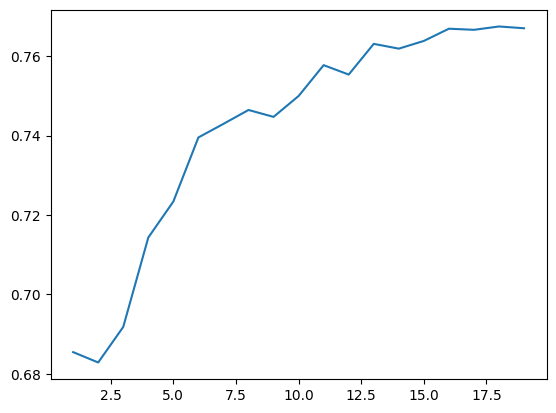

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(1, len(mious)+1)], mious)

5
000
<PIL.Image.Image image mode=L size=512x512 at 0x7FE1DC0EAAE0>
005
<PIL.Image.Image image mode=L size=512x512 at 0x7FE2041ADB80>
010
<PIL.Image.Image image mode=L size=512x512 at 0x7FE1CC26B9E0>
015
<PIL.Image.Image image mode=L size=512x512 at 0x7FE2041AECF0>
020
<PIL.Image.Image image mode=L size=512x512 at 0x7FE23C12E420>


IndexError: index 4 is out of bounds for axis 0 with size 4

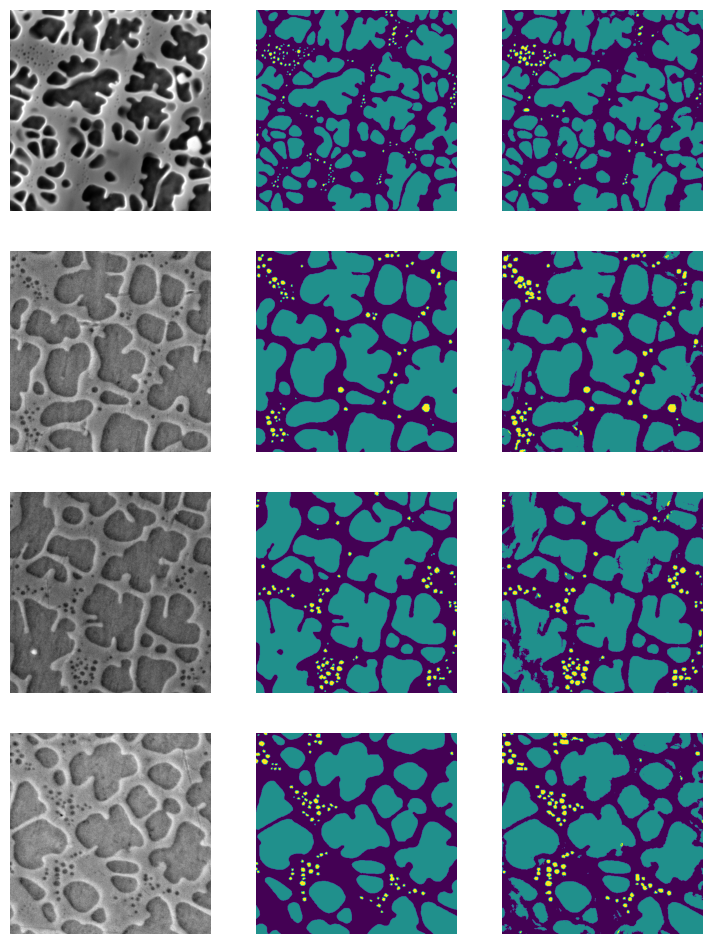

In [ ]:
from PIL import Image
from interactive_seg_backend.file_handling import load_image, load_labels

n_examples = 4
width = 3
fig, axs = plt.subplots(nrows=n_examples, ncols=3, figsize=(width * 3, width * n_examples))

step = len(all_label_fnames) // n_examples
fnames = all_label_fnames[::step]
images = {fname: Image.fromarray(load_image(f"{PATH}/{chosen_dataset}/images/{fname}.tif")) for fname in all_label_fnames}
segs = {fname: (load_labels(f"{PATH}/{chosen_dataset}/segmentations/{fname}.tif")) for fname in all_label_fnames}

for i, fname in enumerate(fnames):
    print(fname)
    print(images[fname])
    # fname = "014.tif"
    axs[i, 0].imshow(images[fname], cmap='binary_r')
    axs[i, 1].imshow(segs[fname])
    axs[i, 2].imshow(preds[f"{fname}.tif"])

    for ax in axs[i]:
        ax.set_axis_off()

plt.tight_layout()